<a href="https://colab.research.google.com/github/Walt9819/factores-impacto-desempleo-mexico/blob/main/Machine_Learning/ML_restaurantes_2clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recuperación económica post-COVID: Localización óptima de restaurantes en México**

La pandemia de COVID-19 afectó a varios sectores de la economía, entre los cuales se cuentra el sector restaurantero. Con el fin de ayudar en la recuperación económica, la presente investigación tiene como objetivo encontrar los municipios donde sería viable abrir un restaurante.

---

Las variables utilizadas, por cada fuente de información, son las siguientes:

*Identificadores:*

- ***imun***:	Identificador por municipio y entidad
- ***ent***:	Clave de la entidad
- ***nom_ent***: Nombre de la entidad	
- ***mun***: Clave del municipio
- ***nom_mun***: Nombre del municipio
- ***CVEGEO***: Clave geográfica

*Censo Nacional de Población y Vivienda:*

- ***pobtot***: Población total

*Encuesta Nacional de Ocupación y Empleo:*

- ***ing_lab***: Ingreso laboral promedio
- ***pea***: Población económicamente activa
- ***ocupada***:	Población ocupada en alguna actividad económica

*Directorio Estadístico Nacional de Unidades Económicas:*

- ***tra_omun***: Población que trabaja en la misma entidad pero en un municipio distinto al de residencia
- ***tot_est***: Total de establecimientos
- ***est_e_a***: Número de establecimientos esenciales
- ***est_n_e_a***: Número de establecimientos no esenciales
- ***tot_p_o***: Personas ocupadas en los establecimientos
- ***po_e_a***: Personas ocupadas en los establecimientos esenciales
- ***po_n_e_a***: Personas ocupadas en los establecimientos no esenciales
- ***comida_carta_corrida***:	Número de restaurantes con servicio de preparación de alimentos a la carta o de comida corrida
- ***antojitos***: Número de restaurantes con servicio de preparación de antojitos
- ***pescados_mariscos***:	Número de restaurantes con servicio de preparación de pescados y mariscos
- ***comida_rapida***: Número de restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar
- ***tacos_tortas***: Número de restaurantes con servicio de preparación de tacos y tortas
- ***autoservicio***: Número de restaurantes de autoservicio
- ***otro_tipo_alimentos***:	Número de restaurantes que preparan otro tipo de alimentos para llevar

*Datos Abiertos de Incidencia Delictiva*

- ***amenazas***: Número de reportes por amenazas
- ***danio_propiedad***:	Número de reportes por daño a la propiedad
- ***extorsion***: Número de reportes por extorsión
- ***robo_negocio***: Número de reportes por robo a negocios


## **Instalación e importación de módulos**

In [101]:
!pip install geopandas
!pip install pandas_bokeh

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import geopandas

import locale
from datetime import datetime
import plotly.express as px
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import dateutil

import pandas_bokeh
pandas_bokeh.output_notebook()
from tqdm import tqdm

## **Lectura de dataset**

In [127]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Machine_Learning/data/data_merge_cluster.csv')
dataframe

imun  ent         nom_ent  ...  danio_propiedad extorsion  robo_negocio
0      1001    1  Aguascalientes  ...             3370        88          1669
1      1002    1  Aguascalientes  ...              116         1            45
2      1003    1  Aguascalientes  ...              139         3            54
3      1004    1  Aguascalientes  ...               35         4            22
4      1005    1  Aguascalientes  ...              404         7           224
...     ...  ...             ...  ...              ...       ...           ...
2458  32054   32       Zacatecas  ...                5         3             0
2459  32055   32       Zacatecas  ...               57         7             3
2460  32056   32       Zacatecas  ...              512        98            62
2461  32057   32       Zacatecas  ...               25        11             2
2462  32058   32       Zacatecas  ...                4         0             0

[2463 rows x 28 columns]

In [128]:
data_tweets = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Machine_Learning/data/data_tweets.csv')
data_tweets.head()

Unnamed: 0                     full_name  ... favorite_count tweet_count
0           1  Acapulco de Juárez, Guerrero  ...       0.392157          51
1           2              Actopan, Hidalgo  ...       2.000000           1
2           4        Aguascalientes, México  ...       0.000000           1
3           5                Ahome, Sinaloa  ...       0.666667           6
4           6             Aldama, Chihuahua  ...       1.000000           1

[5 rows x 10 columns]

In [129]:
data_tweets = data_tweets[['city_full_name',
       'followers_count', 'friends_count', 'favourites_count', 'retweet_count',
       'favorite_count', 'tweet_count']]

In [130]:
data_tweets.columns = ['nom_mun',
       'followers_count', 'friends_count', 'favourites_count', 'retweet_count',
       'favorite_count', 'tweet_count']

In [131]:
dataframe = dataframe.merge(data_tweets, on='nom_mun', how='left')
dataframe = dataframe.fillna(0)

In [132]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','tra_omun'], axis=1)

In [133]:
df

pobtot  ing_lab     pea  ...  retweet_count  favorite_count  tweet_count
0     877190  7676.46  382550  ...            0.0             0.0          1.0
1      46464  5863.52   13914  ...            0.0             0.0          0.0
2      56048  5784.97   20099  ...            0.0             0.0          0.0
3      15577  6096.05    4869  ...            0.0             0.0          0.0
4     120405  6262.18   51020  ...            0.0             0.0          0.0
...      ...      ...     ...  ...            ...             ...          ...
2473   19155  1877.31    4538  ...            0.0             0.0          0.0
2474   30240     0.00    9018  ...            0.0             0.0          0.0
2475  146147  7421.03   60889  ...            0.0             9.0          2.0
2476   19413  6537.04    6039  ...            0.0             0.0          0.0
2477    2656     0.00     710  ...            0.0             0.0          0.0

[2478 rows x 27 columns]

## **Análisis exploratorio**

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 0 to 2477
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pobtot                2478 non-null   int64  
 1   ing_lab               2478 non-null   float64
 2   pea                   2478 non-null   int64  
 3   ocupada               2478 non-null   int64  
 4   tot_est               2478 non-null   int64  
 5   est_e_a               2478 non-null   int64  
 6   est_n_e_a             2478 non-null   int64  
 7   tot_p_o               2478 non-null   int64  
 8   po_e_a                2478 non-null   int64  
 9   po_n_e_a              2478 non-null   int64  
 10  comida_carta_corrida  2478 non-null   int64  
 11  antojitos             2478 non-null   int64  
 12  pescados_mariscos     2478 non-null   int64  
 13  comida_rapida         2478 non-null   int64  
 14  tacos_tortas          2478 non-null   int64  
 15  autoservicio         

In [135]:
round(df.describe(), 2)

pobtot   ing_lab  ...  favorite_count  tweet_count
count     2478.00   2478.00  ...         2478.00      2478.00
mean     49395.20   2043.26  ...            0.25         0.56
std     140369.55   3066.18  ...            1.71         3.38
min          0.00      0.00  ...            0.00         0.00
25%       4246.25      0.00  ...            0.00         0.00
50%      13299.50      0.00  ...            0.00         0.00
75%      34467.50   4380.39  ...            0.00         0.00
max    1827868.00  36323.24  ...           25.00        51.00

[8 rows x 27 columns]

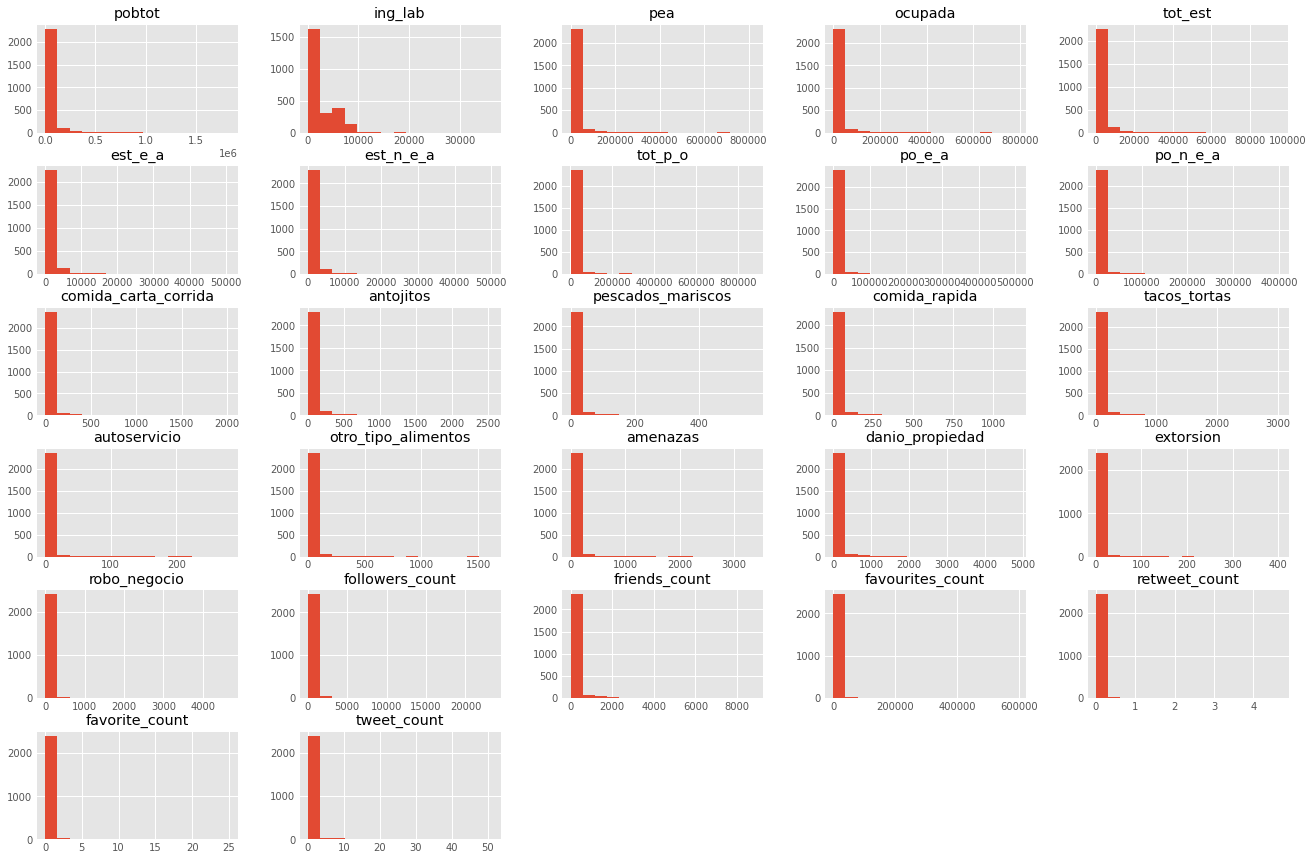

In [136]:
ax = df.hist(bins=15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

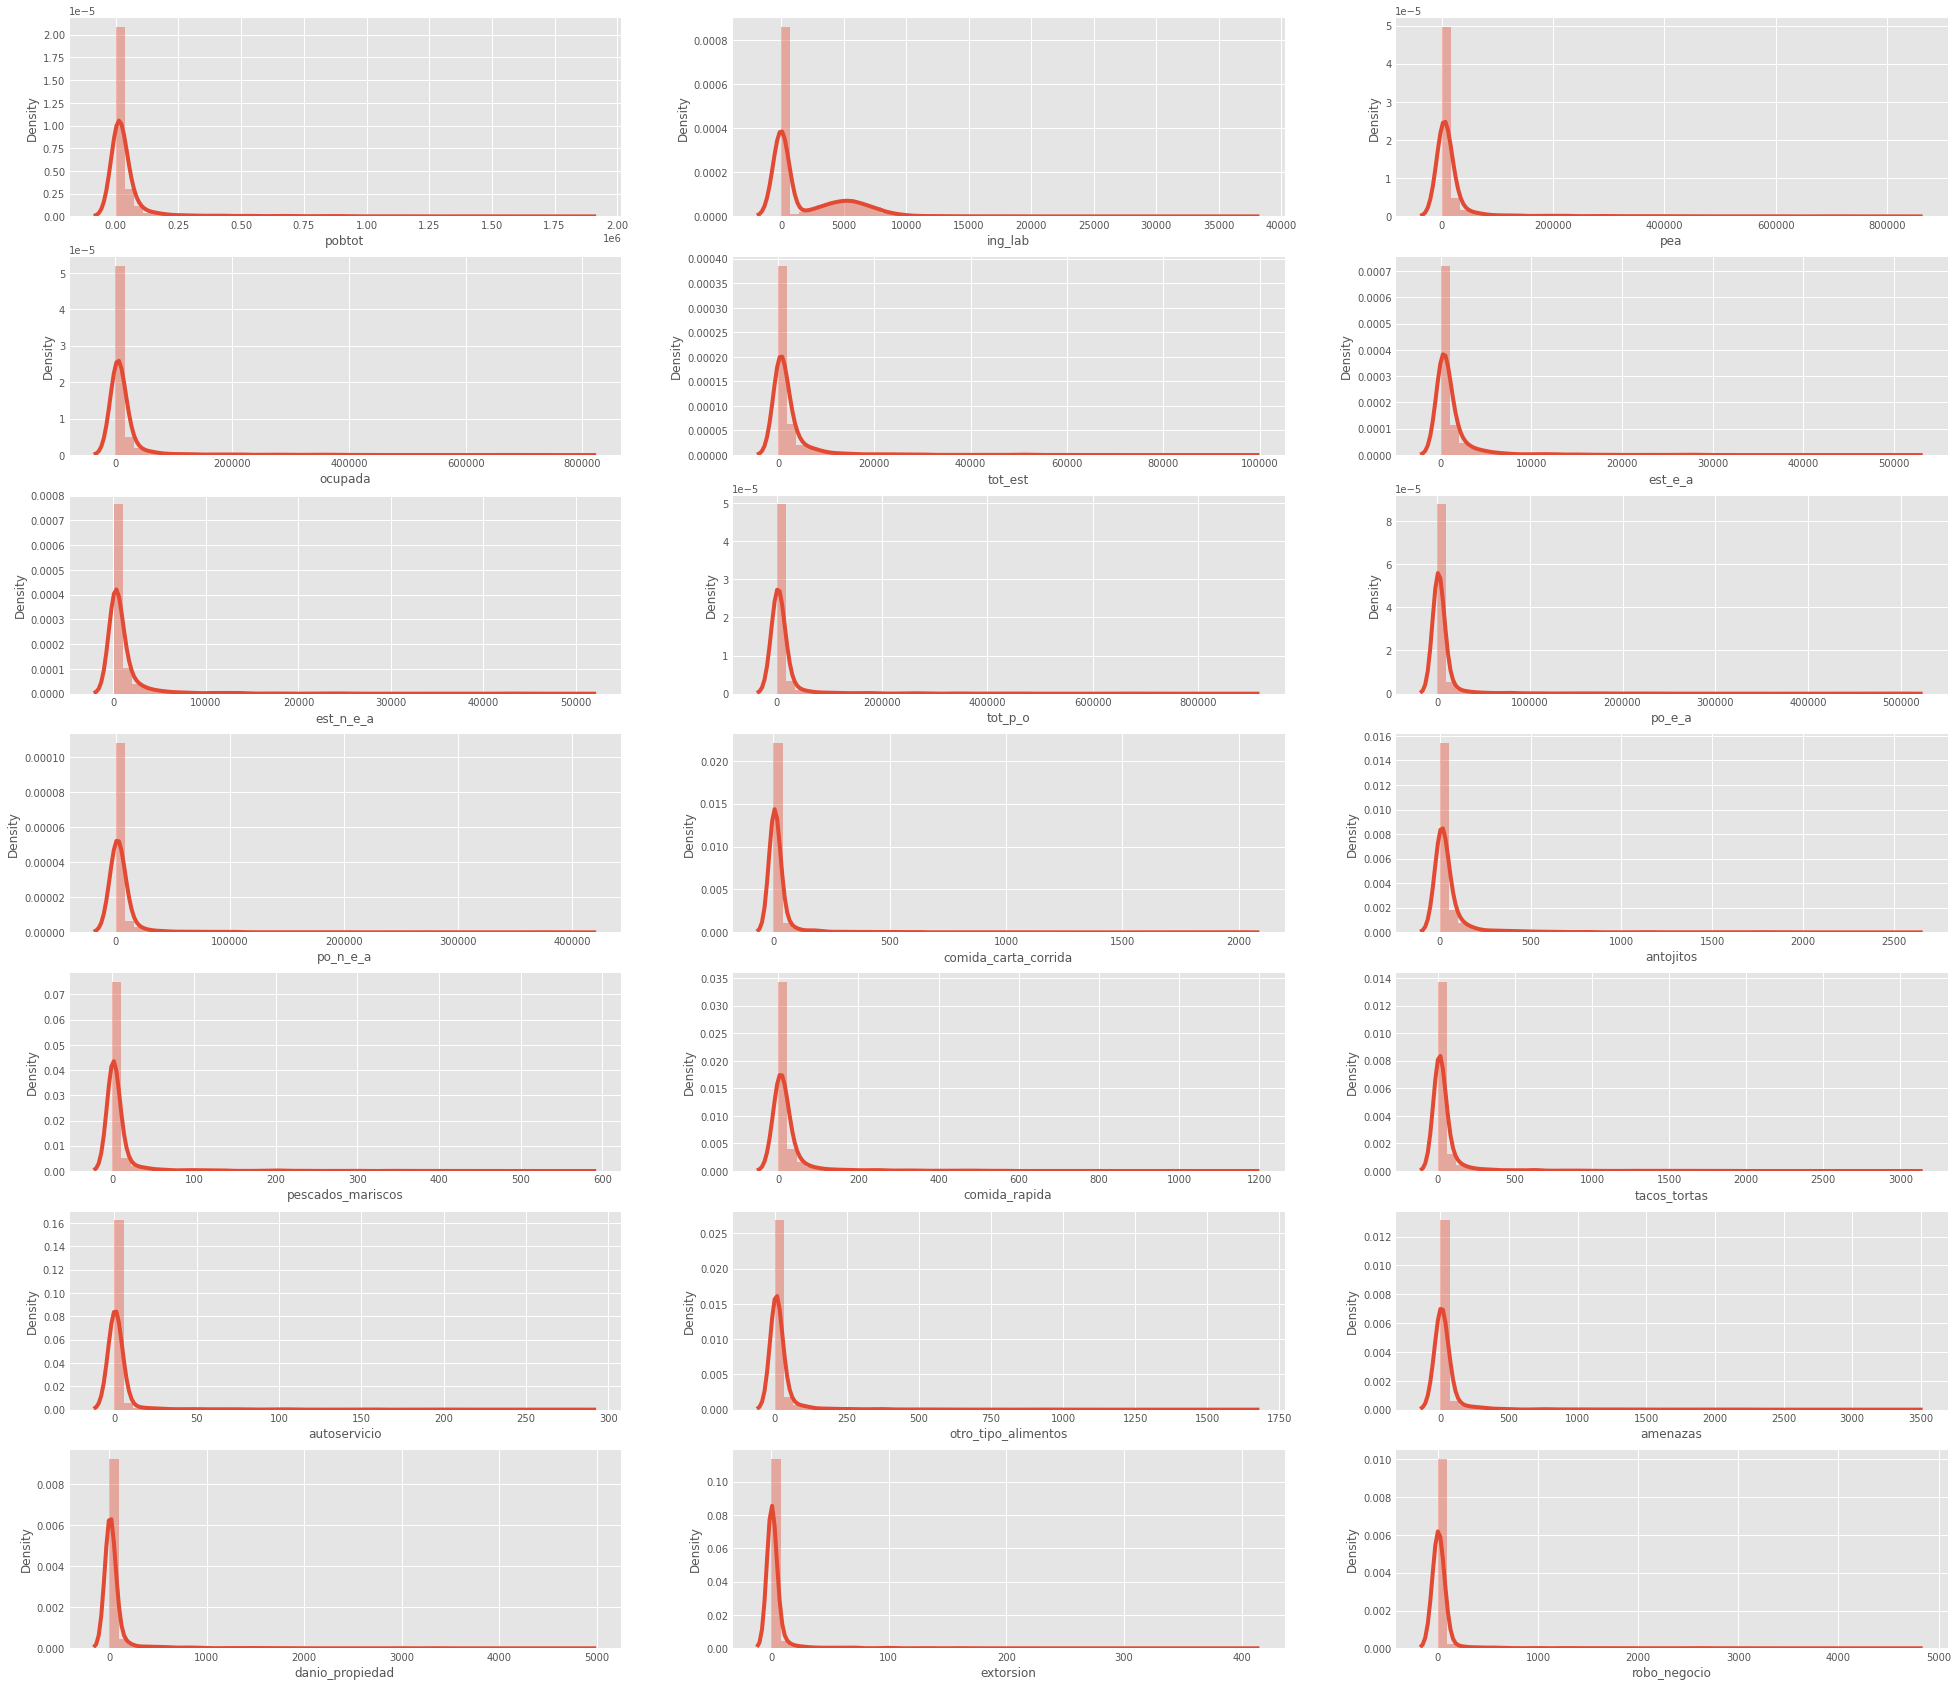

In [137]:
# 'pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est', 'est_e_a', 'est_n_e_a', 'tot_p_o', 'po_e_a', 'po_n_e_a', 'comida_carta_corrida', 'antojitos', 'pescados_mariscos', 
# 'comida_rapida', 'tacos_tortas', 'autoservicio', 'otro_tipo_alimentos', 'amenazas', 'danio_propiedad','extorsion', 'robo_negocio'
f, axes = plt.subplots(7,3, figsize=(30,30))
sns.distplot(df.pobtot, ax=axes[0,0])
sns.distplot(df.ing_lab, ax=axes[0,1])
sns.distplot(df.pea, ax=axes[0,2])
sns.distplot(df.ocupada, ax=axes[1,0])
sns.distplot(df.tot_est, ax=axes[1,1])
sns.distplot(df.est_e_a, ax=axes[1,2])
sns.distplot(df.est_n_e_a, ax=axes[2,0])
sns.distplot(df.tot_p_o, ax=axes[2,1])
sns.distplot(df.po_e_a, ax=axes[2,2])
sns.distplot(df.po_n_e_a, ax=axes[3,0])
sns.distplot(df.comida_carta_corrida, ax=axes[3,1])
sns.distplot(df.antojitos, ax=axes[3,2])
sns.distplot(df.pescados_mariscos, ax=axes[4,0])
sns.distplot(df.comida_rapida, ax=axes[4,1])
sns.distplot(df.tacos_tortas, ax=axes[4,2])
sns.distplot(df.autoservicio, ax=axes[5,0])
sns.distplot(df.otro_tipo_alimentos, ax=axes[5,1])
sns.distplot(df.amenazas, ax=axes[5,2])
sns.distplot(df.danio_propiedad, ax=axes[6,0])
sns.distplot(df.extorsion, ax=axes[6,1])
sns.distplot(df.robo_negocio, ax=axes[6,2])



## **Normalización de datos**

Para ayudar a nuestro algoritmo K-Means en la interpretación de características con diferentes magnitudes y distribuciones, se normalizaron los datos y  se aplicó PCA (Principal Component Analysis) para reducir dimensiones del espacio de características original, debido a que nos cuestionamos ¿cuáles atributos deberíamos elegir para obtener buenas predicciones o agrupamientos, sin perder información valiosa?  

In [138]:
scaler = StandardScaler()

scaler.fit(df) # Calcula la media y estandar para cada dimensión
X_scaled=scaler.transform(df) # Transforma los datos a su nueva escala

In [139]:
X_scaled

array([[ 5.89844375,  1.83757847,  5.8699753 , ..., -0.09813077,
        -0.1461431 ,  0.1291394 ],
       [-0.02088621,  1.24618869, -0.09058114, ..., -0.09813077,
        -0.1461431 , -0.16634299],
       [ 0.04740449,  1.2205653 ,  0.00942549, ..., -0.09813077,
        -0.1461431 , -0.16634299],
       ...,
       [ 0.68940403,  1.75425597,  0.66896795, ..., -0.09813077,
         5.12563137,  0.42462179],
       [-0.21363785,  1.46589417, -0.21791374, ..., -0.09813077,
        -0.1461431 , -0.16634299],
       [-0.33303969, -0.66651984, -0.30407951, ..., -0.09813077,
        -0.1461431 , -0.16634299]])

## **Busquéda de los componentes principales con algoritmo PCA**

In [140]:
pca = PCA(n_components=5)
#pca=PCA(.85)
pca.fit(X_scaled) # Buscar los componentes principales
X_pca=pca.transform(X_scaled) 
#Se revisa la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (2478, 5)


De tal manera que elegir arbitrariamente las dimensiones a considerar dentro del algoritmo no supervisado, no era la opción, así que optamos por calcular la proporción de variación explicada con la cual alcanzamos a explicar 94.07% de la variabilidad total con 5 componentes. 

## Varianza explicada

Varianza explicada del **94%**con los componentes principales calculados en el segmento de código anterior.

In [141]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))
# Con 5 componentes tenemos algo mas del 97% de varianza explicada

[0.66381903 0.09424316 0.03805498 0.03550067 0.02982206]
suma: 0.8614399013640347


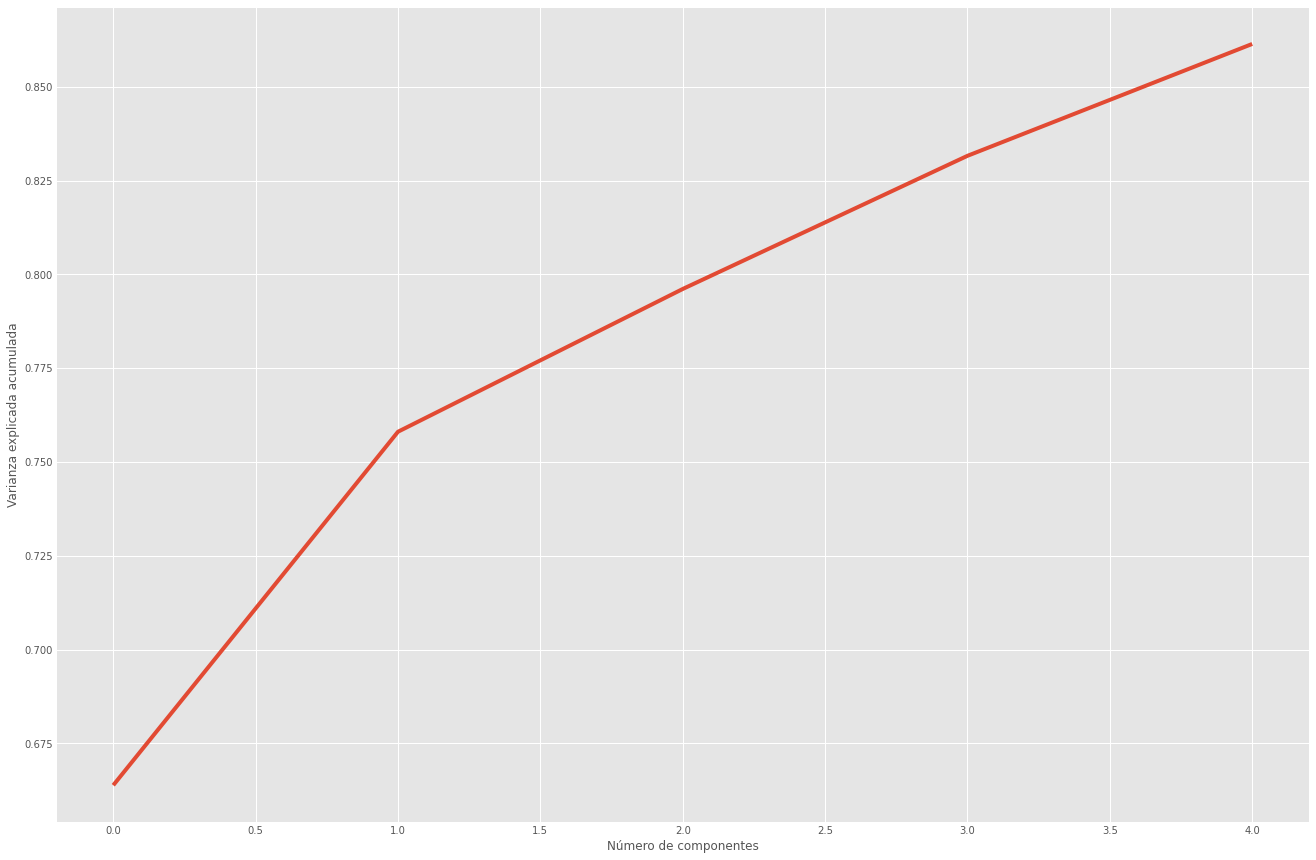

In [142]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

No handles with labels found to put in legend.


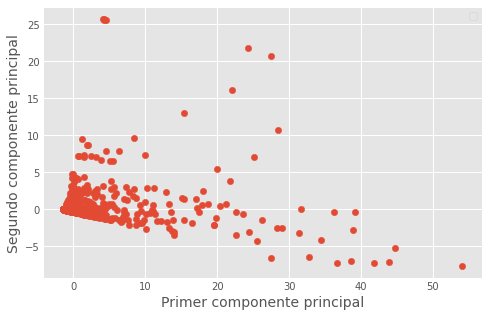

In [143]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ax.scatter(Xax,Yax,s=40)

plt.xlabel("Primer componente principal",fontsize=14)
plt.ylabel("Segundo componente principal",fontsize=14)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



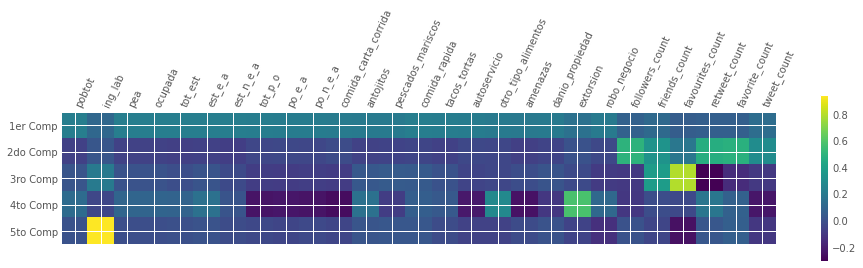

In [144]:
plt.matshow(pca.components_[0:5],cmap='viridis')
plt.yticks([0,1,2,3,4],['1er Comp','2do Comp','3ro Comp','4to Comp','5to Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show();

In [145]:
components = pd.DataFrame(pca.components_, columns = df.columns)
components.shape

(5, 27)

## Algoritmo K-Means

Después de deshacernos de los autovectores de menor importancia relativa, se identificó el número óptimo de grupos a definir en nuestro algoritmo K-means. Se utilizó la distancia media al centroide en función de k y se encontró el punto codo donde la tasa de descenso se quiebra o se afila.

In [146]:
import sklearn.cluster as cluster

inertia = []
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

100%|██████████| 8/8 [00:02<00:00,  3.75it/s]


In [147]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    silhouette[i] = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


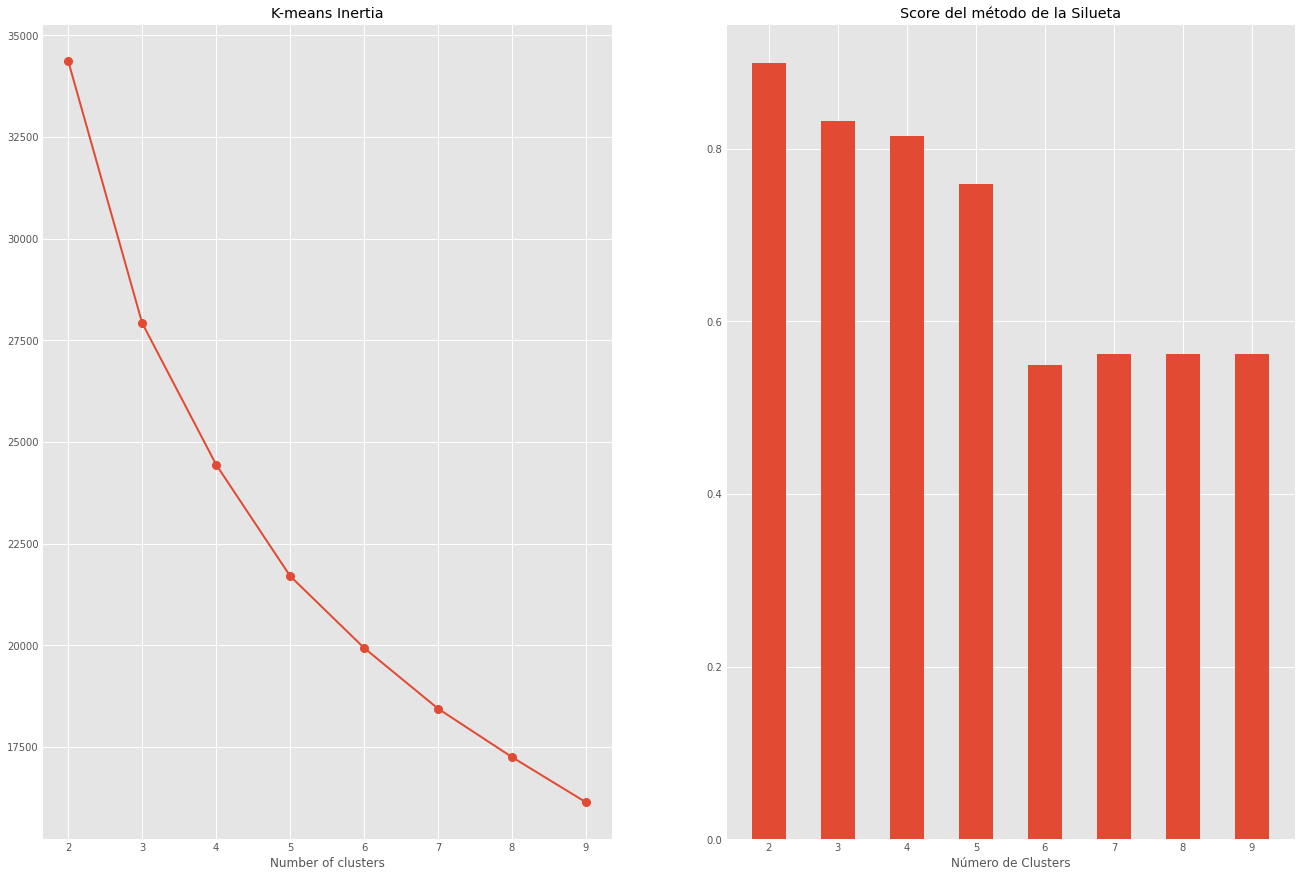

In [148]:
plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8)
plt.xlabel('Number of clusters')
plt.title('K-means Inertia')

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.title('Score del método de la Silueta')
plt.xlabel('Número de Clusters')

plt.show()

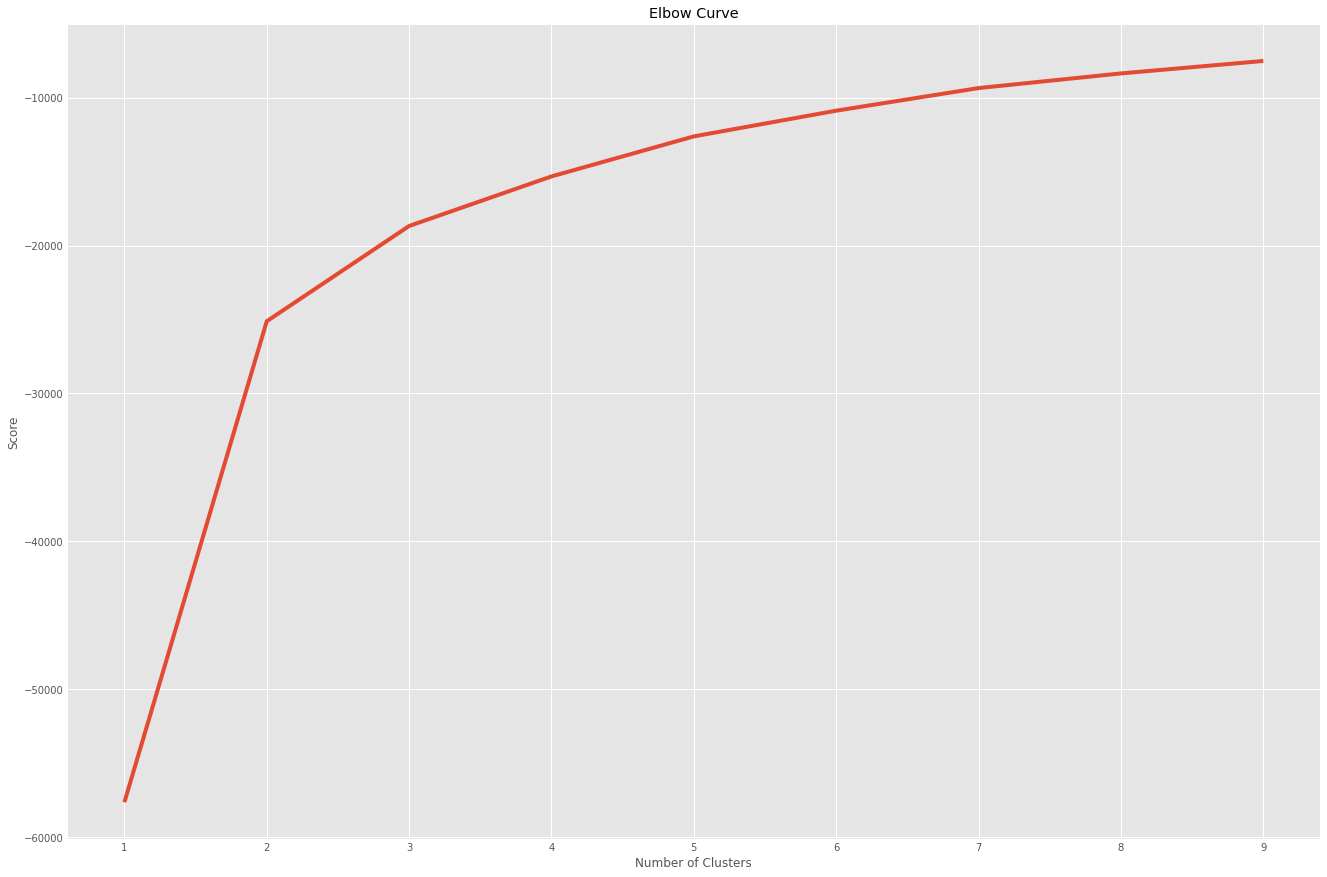

In [149]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]
score

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A nuestro criterio y con la gráfica de la curva de codo, se consideró que 2 era buen número para el valor K. Ejecutamos el algoritmo para 2 clusters, y graficamos con colores los grupos para ver si se lograban diferenciar entre ellos presentando una buena separación y compactación.  

In [150]:
# Para el proyecto, se eligio el valor 2 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=2).fit(X_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-5.45423778e-01  5.67738283e-04  1.11513459e-02  9.69748384e-03
   1.31263250e-02]
 [ 2.40283966e+01 -2.50114520e-02 -4.91267474e-01 -4.27218243e-01
  -5.78274279e-01]]


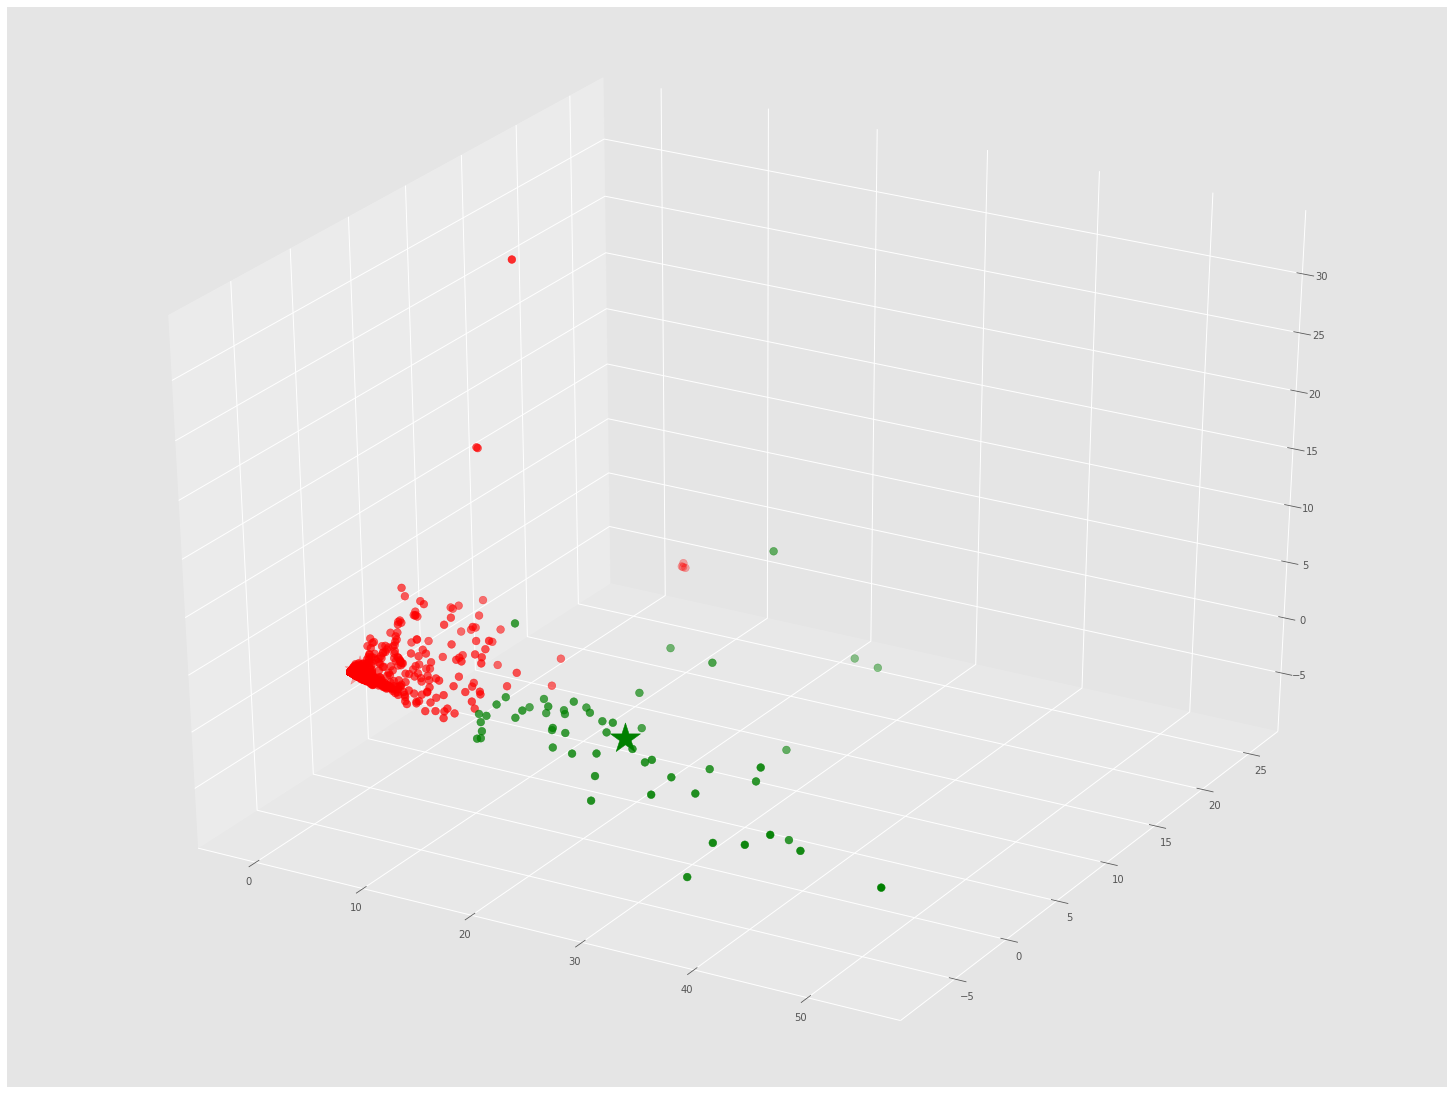

In [151]:
# Se obtienen las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X_pca)
# Se obtienen los centroids
C = kmeans.cluster_centers_
colores=['red','green']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [152]:
# Se cuentan los usuarios que hay en cada grupo
copy =  pd.DataFrame()
copy['imun']=dataframe['imun'].values
copy['ent']=dataframe['ent'].values
copy['nom_ent']=dataframe['nom_ent'].values
copy['mun']=dataframe['mun'].values
copy['nom_mun']=dataframe['nom_mun'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

color  cantidad
0    red      2423
1  green        55

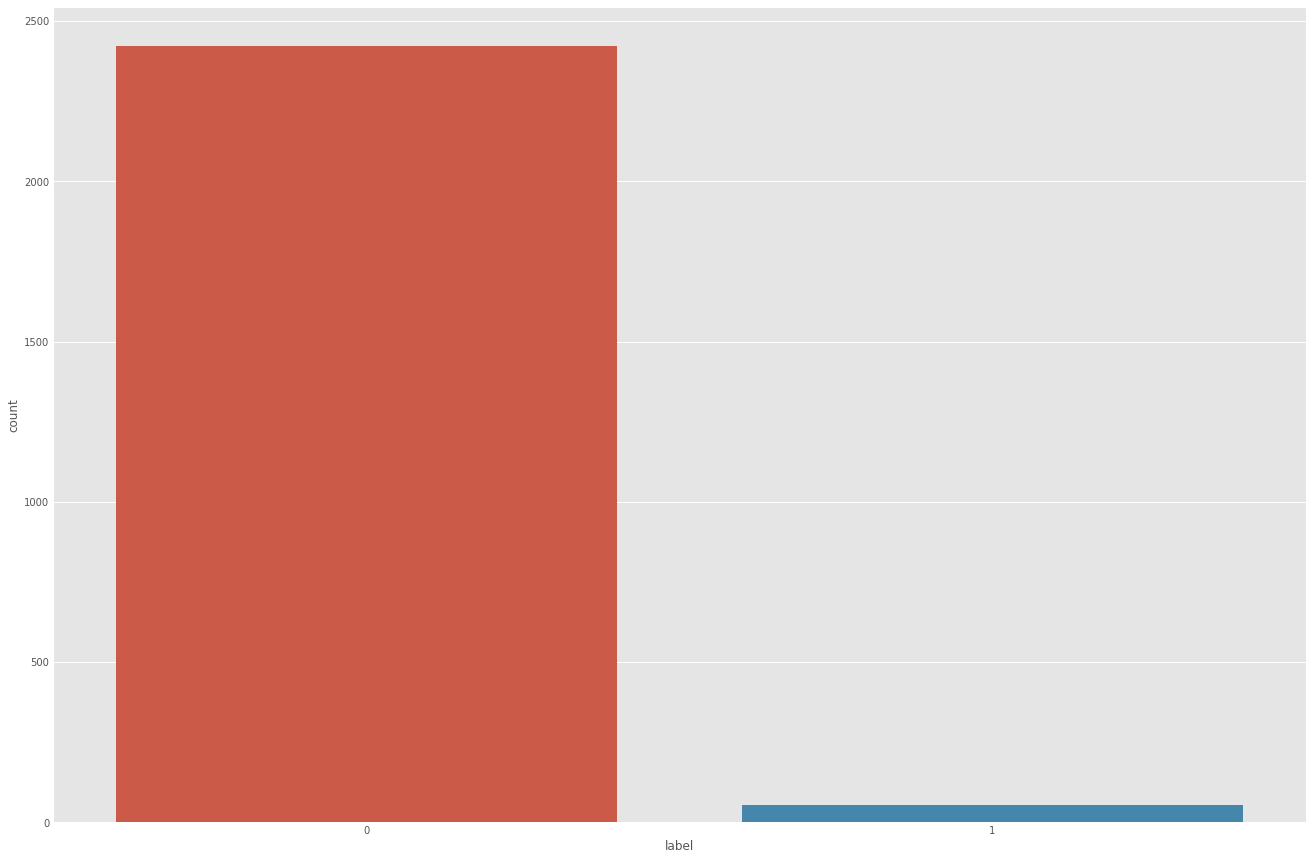

In [153]:
sns.countplot(x=copy.label)

In [154]:
copy.head()

imun  ent         nom_ent  mun         nom_mun  label
0  1001    1  Aguascalientes    1  Aguascalientes      1
1  1002    1  Aguascalientes    2        Asientos      0
2  1003    1  Aguascalientes    3        Calvillo      0
3  1004    1  Aguascalientes    4           Cosío      0
4  1005    1  Aguascalientes    5     Jesús María      0

In [155]:
column_values = ['C1','C2','C3','C4','C5']  
df_pca = pd.DataFrame(data = X_pca,    
                  columns = column_values) 

In [156]:
df_pca['CVEGEO']=dataframe['CVEGEO'].values
df_pca['imun']=dataframe['imun'].values
df_pca['ent']=dataframe['ent'].values
df_pca['nom_ent']=dataframe['nom_ent'].values
df_pca['mun']=dataframe['mun'].values
df_pca['nom_mun']=dataframe['nom_mun'].values
df_pca['label'] = labels;
df_pca['pobtot']=dataframe['pobtot'].values
df_pca['ing_lab']=dataframe['ing_lab'].values
df_pca['pea']=dataframe['pea'].values
df_pca['ocupada']=dataframe['ocupada'].values
df_pca['tot_est']=dataframe['tot_est'].values
df_pca

C1        C2        C3  ...     pea  ocupada  tot_est
0     27.476891 -6.641686 -0.828295  ...  382550   367528    46426
1     -0.476477 -0.187313  0.203052  ...   13914    13108      989
2      0.128215 -0.330671  0.177362  ...   20099    19352     3280
3     -0.809705 -0.089071  0.206405  ...    4869     4627     1000
4      2.375463 -0.848227  0.046464  ...   51020    49795     6377
...         ...       ...       ...  ...     ...      ...      ...
2473  -1.116120 -0.090512 -0.048763  ...    4538     4324      423
2474  -0.411749 -0.295972 -0.183738  ...    9018     8176     3532
2475   5.708622  2.963125  0.753360  ...   60889    58330     9716
2476  -0.774185 -0.073464  0.245705  ...    6039     5703      665
2477  -1.337020 -0.074483 -0.184894  ...     710      643      173

[2478 rows x 17 columns]

## Interpretación de los grupos resultantes

**Grupo 0**: el número de municipios contenidos corresponde a 2,411.

**Grupo 1**: está conformado por 52 municipios.


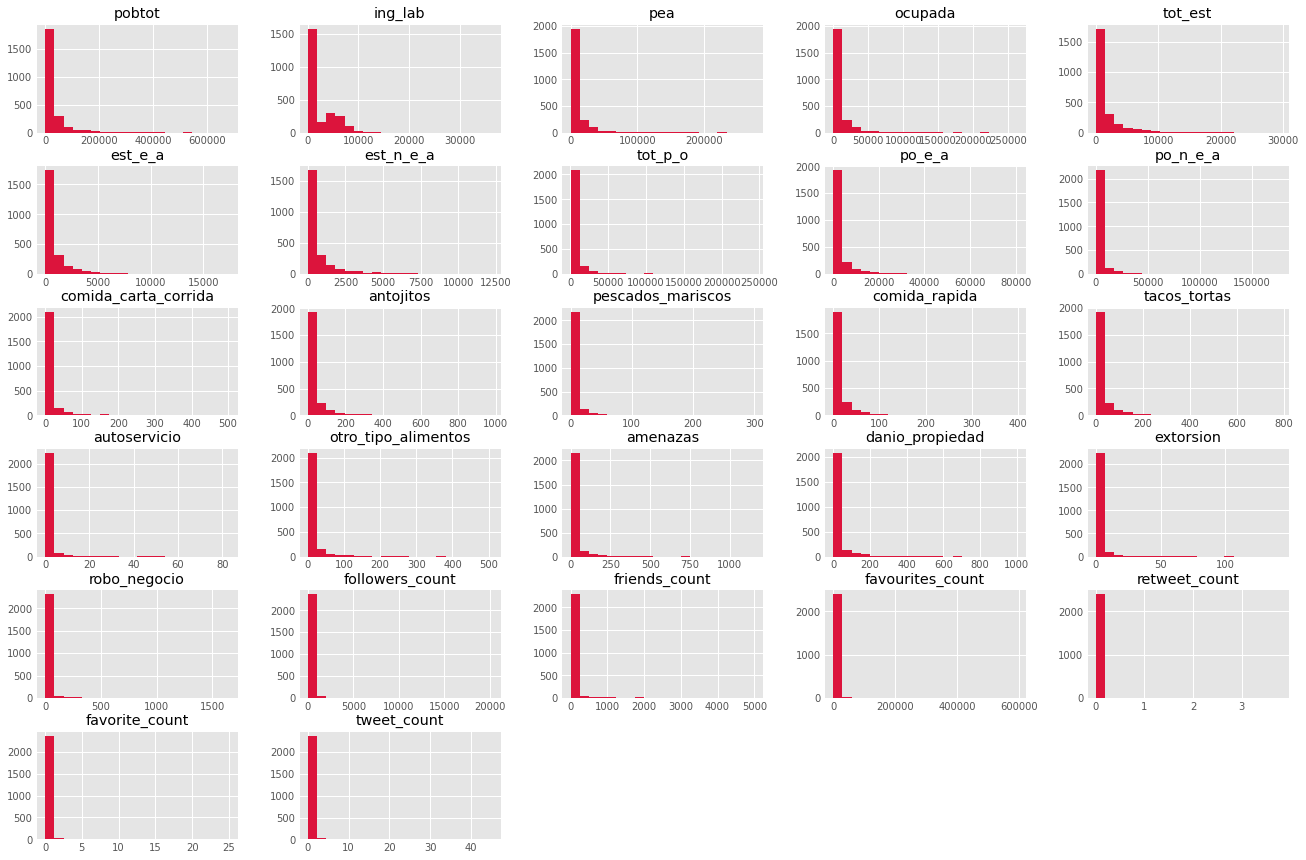

In [157]:
dataframe2 = df.copy()
dataframe2['Cluster'] = labels

aux = dataframe2.columns.tolist()
aux = aux[0:len(aux)-1]

# Grupo 0 

data_grupo0 = dataframe2[dataframe2['Cluster'] == 0]

data_grupo0[aux].hist(bins=20, color='#DC143C');

In [158]:
round(data_grupo0[aux].describe(), 2)

pobtot   ing_lab  ...  favorite_count  tweet_count
count    2423.0   2423.00  ...         2423.00      2423.00
mean    32199.6   1902.70  ...            0.19         0.29
std     61033.5   2927.82  ...            1.50         2.33
min         0.0      0.00  ...            0.00         0.00
25%      4104.0      0.00  ...            0.00         0.00
50%     12783.0      0.00  ...            0.00         0.00
75%     31487.5   4129.12  ...            0.00         0.00
max    679811.0  36323.24  ...           25.00        45.00

[8 rows x 27 columns]

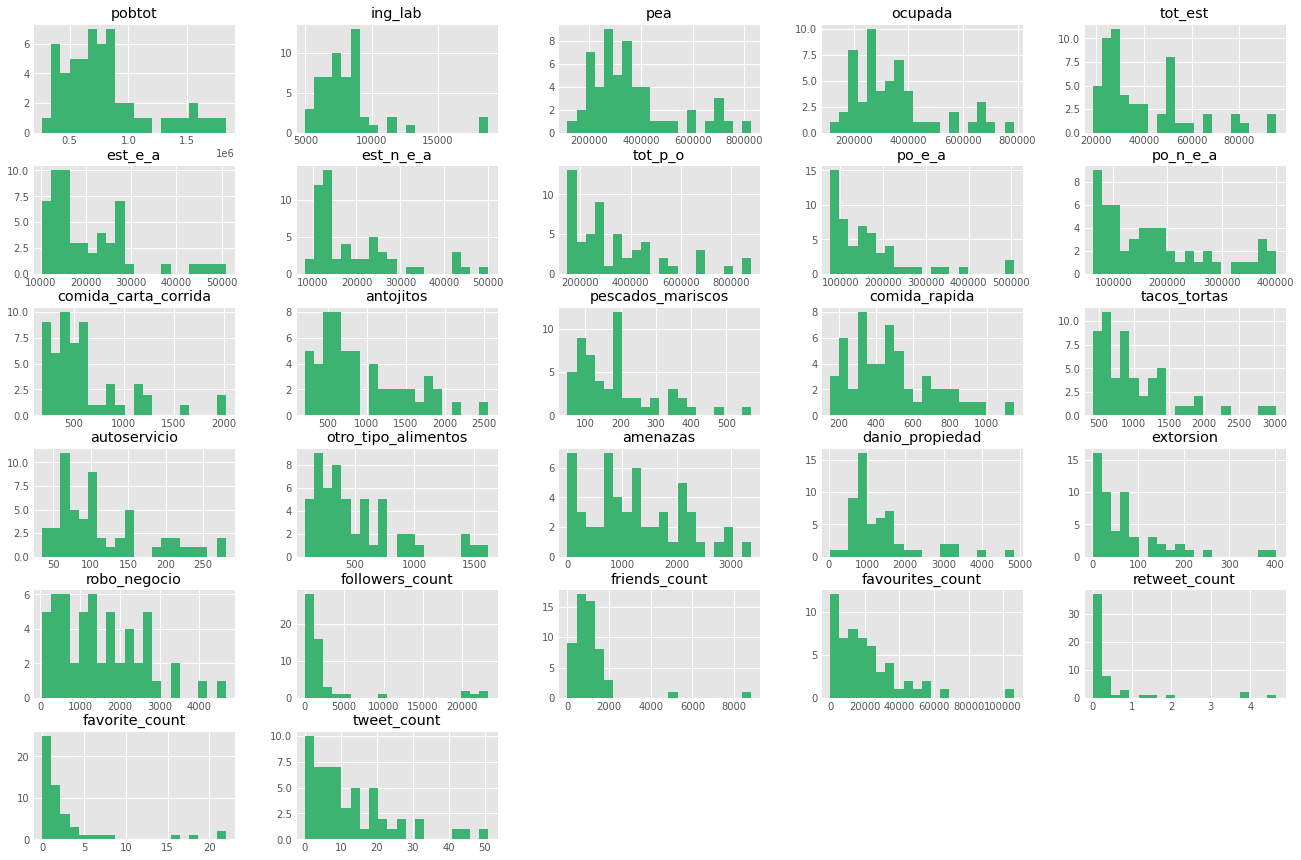

In [159]:
# Grupo 1

data_grupo1 = dataframe2[dataframe2['Cluster'] == 1]

data_grupo1[aux].hist(bins=20, color='#3CB371');

In [160]:
round(data_grupo1[aux].describe(), 2)

pobtot   ing_lab  ...  favorite_count  tweet_count
count       55.00     55.00  ...           55.00        55.00
mean    806939.47   8235.54  ...            2.98        12.49
std     372782.11   2613.50  ...            4.98        11.54
min     264251.00   4941.37  ...            0.00         0.00
25%     532553.00   6708.08  ...            0.68         4.00
50%     700734.00   7741.85  ...            1.33         9.00
75%     888318.00   8840.63  ...            2.72        18.00
max    1827868.00  18849.13  ...           21.94        51.00

[8 rows x 27 columns]

In [161]:
mask = (df_pca.label == 1)
df_pca.loc[mask]

C1         C2        C3  ...     pea  ocupada  tot_est
0     27.476891  -6.641686 -0.828295  ...  382550   367528    46426
11    13.327047   0.718450  6.827014  ...  210634   204081    23766
12    25.476022  -4.275067 -0.686733  ...  429396   411812    35876
14    38.661768  -7.000837 -1.683728  ...  741226   714819    58150
61    17.134497   0.135009 -1.378987  ...  339023   327417    29574
66    19.901692   5.454864 -0.842287  ...  284835   270281    28868
180   22.091138  16.045584  5.715117  ...  263449   253096    40519
223   22.671929  -0.384330 -0.000663  ...  390819   377117    36291
242   32.783260  -6.556833  0.859443  ...  597127   575889    39929
273   15.385218  13.005758 -2.560740  ...  188982   180813    18496
274   17.981420   2.461587 -0.672228  ...  290836   280561    24575
276   28.941800  -2.582566  0.420948  ...  521596   498501    51665
278   41.826669  -7.358896 -0.868015  ...  825520   786218    83693
281   19.771636  -1.254908 -0.144256  ...  362370   351409    24686
283   17.939533   0.542502 -0.032318  ...  319578   307257    26957
285   24.312989  21.837325 -7.086536  ...  231284   223843    25793
286   20.445455   0.338796  0.774204  ...  231284   223843    25793
287   36.671035  -7.304524 -4.942260  ...  282035   269664    65185
288   39.140307  -0.416699 -5.745709  ...  282035   269664    65185
289   21.799080   3.726134 -2.464967  ...  193221   187477    24279
290   15.426255  -1.468040  0.365143  ...  203507   194371    30721
295   16.544724  -1.916759  1.538234  ...  268590   257657    28673
336   13.747230  -2.968343 -0.856497  ...  207687   200795    29964
346   13.307927  -2.518141  0.179375  ...  226555   214534    24331
349   43.864944  -7.163062  0.341768  ...  703468   680898    79402
376   25.051633   7.069367  1.950533  ...  331914   316765    38630
580   54.037155  -7.707676 -1.463951  ...  666171   640805    95568
639   13.935730  -3.481249 -0.521443  ...  286851   274024    23877
661   34.439341  -4.234113 -0.193973  ...  599709   578546    50184
699   38.939408  -2.871850  2.211193  ...  701545   662037    77286
723   19.587910  -2.223493 -0.841901  ...  362717   346719    32454
724   22.645243  -3.504898  0.142345  ...  455369   435543    50033
770   17.446535  -0.466617  1.171649  ...  306496   292515    29888
772   28.384982  10.707510 -7.459014  ...  360282   343736    50758
787   12.208629  -1.607784  0.076801  ...  223430   212970    19841
844   24.437844  -3.078914  0.279163  ...  335395   320793    50738
911   15.385935   1.348407 -1.034911  ...  169220   161323    25752
954   13.804648  -1.550478  1.228655  ...  182871   177916    26712
983   15.120048   1.429839  0.113714  ...  302761   292445    21881
984   14.049245  -3.145346 -0.053827  ...  302761   292445    21881
997   36.190064  -0.425100 -1.234895  ...  482835   466408    55841
1076  13.070418  -1.776419  0.210366  ...  116220   112276    30057
1694  44.745551  -5.288532 -2.105563  ...  683966   655995    94850
1811  31.396223  -3.308579 -0.074073  ...  404974   390239    50975
1820  27.460001  20.775387 -6.585655  ...  361291   351489    27043
1821  23.592467  -0.723143  1.275085  ...  361291   351489    27043
1855  28.289534  -2.557361  0.034517  ...  369709   356728    50118
1891  26.165364  -1.538755  0.067895  ...  378953   366171    48418
1897  13.529111  -0.452241  1.113873  ...  216605   209914    22908
1933  21.253521   0.658061 -0.003298  ...  402049   386978    36265
1980  19.543189  -2.147169  0.828322  ...  294069   279709    33057
2025  12.866982   2.303455 -1.682436  ...  269357   258152    21386
2185  17.023125   1.359375 -0.418268  ...  214162   206476    29815
2292  18.694404   0.621856  1.182117  ...  265644   254457    27135
2361  31.637106  -0.014485 -1.459760  ...  409580   400697    52728

[55 rows x 17 columns]

In [162]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [163]:
mun_geo = geopandas.read_file("https://github.com/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/data/mun2019gw.zip?raw=true")

In [164]:
# Se transforma a la clave geográfica de int a str, para hacer merge
df_pca['CVEGEO'] = df_pca['CVEGEO'].astype(str)
df_pca['CVEGEO'] = df_pca['CVEGEO'].str.zfill(5)

In [165]:
mun_geo

CVEGEO  ...                                           geometry
0     01001  ...  POLYGON ((-102.10641 22.06035, -102.10368 22.0...
1     01002  ...  POLYGON ((-102.05189 22.29144, -102.05121 22.2...
2     01003  ...  POLYGON ((-102.68569 22.09963, -102.69087 22.0...
3     01004  ...  POLYGON ((-102.28787 22.41649, -102.28753 22.4...
4     01005  ...  POLYGON ((-102.33568 22.05067, -102.33348 22.0...
...     ...  ...                                                ...
2460  32054  ...  POLYGON ((-101.69490 22.51777, -101.69472 22.5...
2461  32055  ...  POLYGON ((-102.78252 22.67373, -102.78221 22.6...
2462  32056  ...  POLYGON ((-102.76690 22.84147, -102.76619 22.8...
2463  32057  ...  POLYGON ((-102.22547 22.80920, -102.22946 22.7...
2464  32058  ...  POLYGON ((-103.38994 21.57379, -103.38332 21.5...

[2465 rows x 10 columns]

In [166]:
mun_pca_merge = pd.merge(mun_geo, df_pca, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')

In [167]:
mun_pca_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2480 entries, 0 to 2479
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CVEGEO     2480 non-null   object  
 1   CVE_ENT    2480 non-null   object  
 2   CVE_MUN    2480 non-null   object  
 3   NOM_ENT    2480 non-null   object  
 4   AREA       2480 non-null   float64 
 5   PERIMETER  2480 non-null   float64 
 6   COV_       2480 non-null   int64   
 7   COV_ID     2480 non-null   int64   
 8   NOM_MUN    2480 non-null   object  
 9   geometry   2480 non-null   geometry
 10  C1         2478 non-null   float64 
 11  C2         2478 non-null   float64 
 12  C3         2478 non-null   float64 
 13  C4         2478 non-null   float64 
 14  C5         2478 non-null   float64 
 15  imun       2478 non-null   float64 
 16  ent        2478 non-null   float64 
 17  nom_ent    2478 non-null   object  
 18  mun        2478 non-null   float64 
 19  nom_mun    2478 non

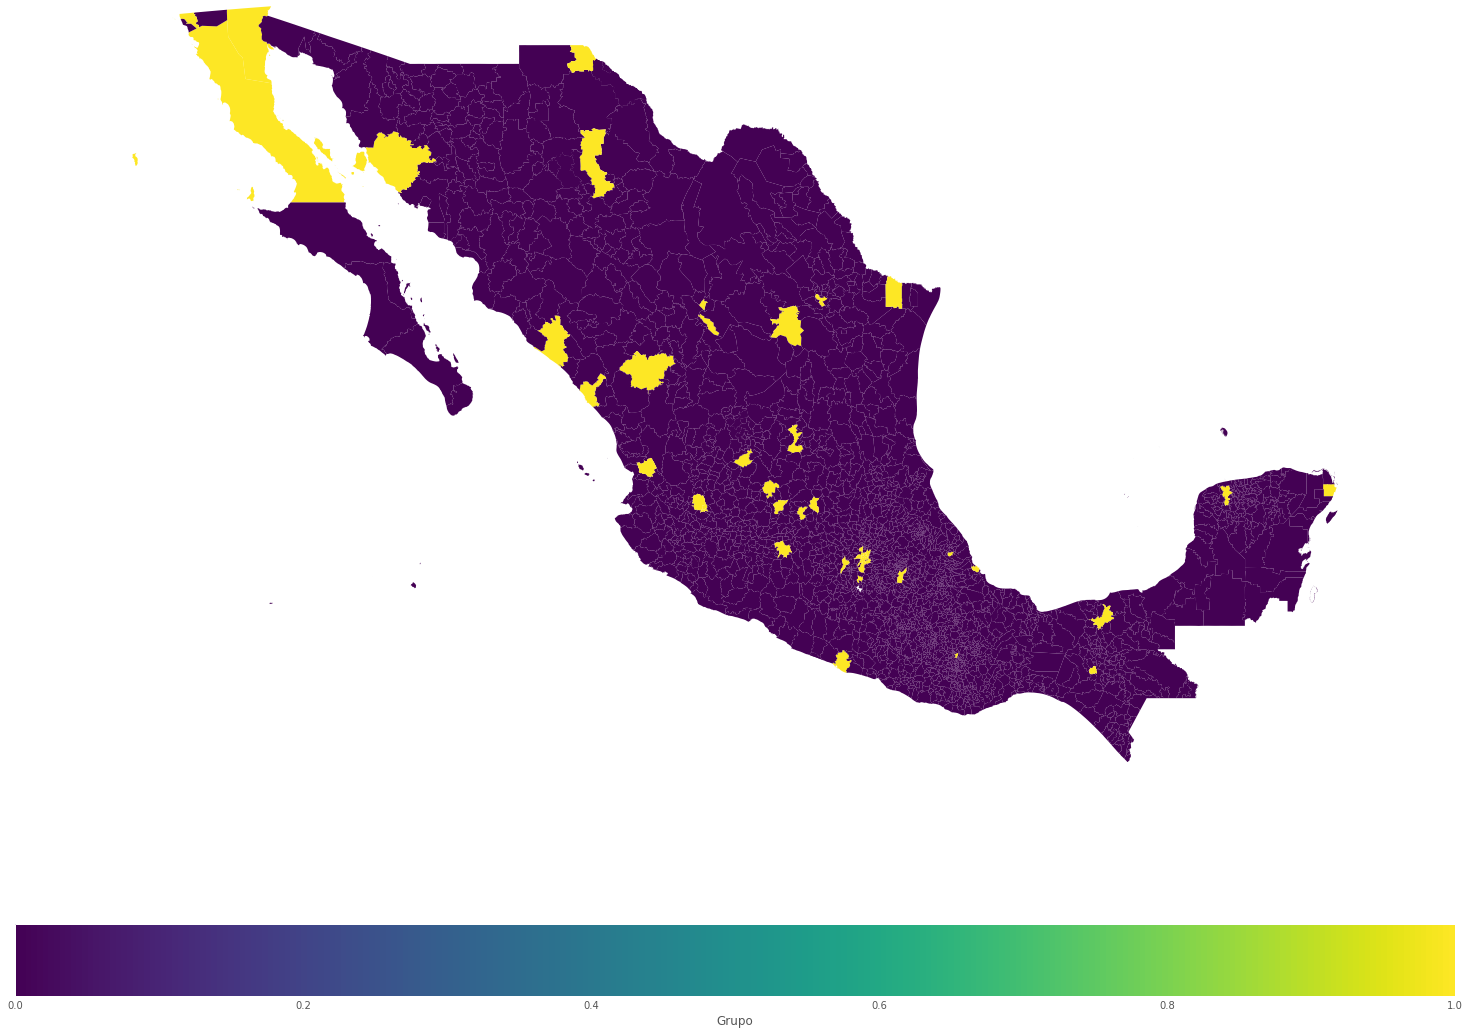

In [168]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

mun_pca_merge.plot(ax=ax, column='label', legend=True, legend_kwds={'label': "Grupo", 
                                                                    'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

In [169]:
# Grupo 0 Rojo, Grupo 1 Verde
mun_pca_merge.plot_bokeh(
    figsize=(900, 600),
    simplify_shapes=500,
    category="label",
    show_colorbar=False,
    colormap=['#DC143C', '#3CB371'],
    hovertool_columns=["nom_ent",'nom_mun', "label"],
    tile_provider="STAMEN_TERRAIN_RETINA")

Figure(id='1133', ...)

## Validación del modelo de datos

Para validar nuestro modelo dividimos el conjunto de datos resultantes del K-Means en un set de entrenamiento y otro pruebas, y aplicamos un modelo de regresión logística y otra de random forest para hacer las predicciones.  La matriz de confusión  muestra cuántos resultados equivocados tuvo cada clase. La valoración que nos conviene analizar es la de F1-score que toma en cuenta la precisión y recall. El promedio de F1 para ambos modelos fluctua entre 96% - 99%.

In [170]:
df_pca.columns

Index(['C1', 'C2', 'C3', 'C4', 'C5', 'CVEGEO', 'imun', 'ent', 'nom_ent', 'mun',
       'nom_mun', 'label', 'pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est'],
      dtype='object')

In [171]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pobtot', 'ing_lab', 'pea', 'ocupada', 'tot_est'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [172]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [173]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

### Regresión logística

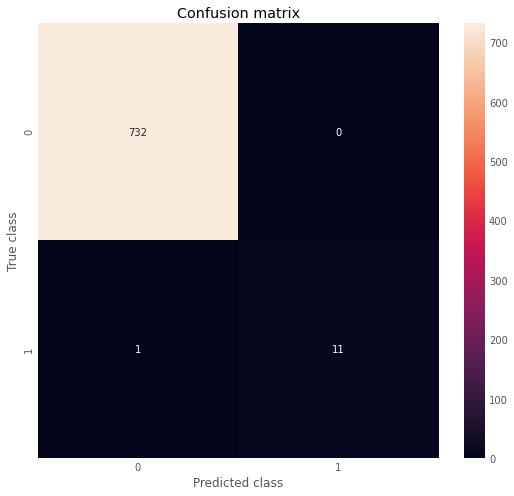

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      0.92      0.96        12

    accuracy                           1.00       744
   macro avg       1.00      0.96      0.98       744
weighted avg       1.00      1.00      1.00       744



In [174]:
LABELS = [0,1]
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## Random Forest

In [175]:
from sklearn.ensemble import RandomForestClassifier
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


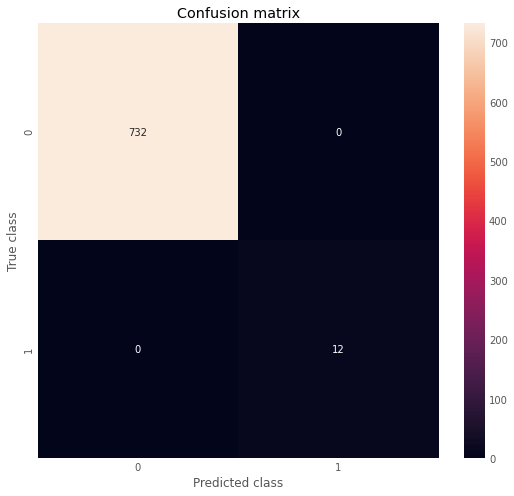

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00        12

    accuracy                           1.00       744
   macro avg       1.00      1.00      1.00       744
weighted avg       1.00      1.00      1.00       744



In [176]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## Red neuronal

In [177]:
from sklearn.preprocessing import Normalizer

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import Normalizer
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
%matplotlib inline
#plt.style.use('fivethirtyeight')

In [178]:
# Se preparan los datos en conjunto de entrenamiento y de prueba. Se normalizan los datos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
nl = Normalizer()
nl.fit(X_train)
X_train = nl.transform(X_train)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)
X_dev = nl.transform(X_dev)
X_test = nl.transform(X_test)

In [179]:
# La arquitectura de la red completa tres capas ocultas y una capa de salida con una activación sigmoide.
def nn():
    inputs = Input(name='inputs', shape=[X_train.shape[1],])
    layer = Dense(128, name='FC1')(inputs)
    layer = BatchNormalization(name='BC1')(layer)
    layer = Activation('relu', name='Activation1')(layer)
    layer = Dropout(0.3, name='Dropout1')(layer)
    layer = Dense(128, name='FC2')(layer)
    layer = BatchNormalization(name='BC2')(layer)
    layer = Activation('relu', name='Activation2')(layer)
    layer = Dropout(0.3, name='Dropout2')(layer)
    layer = Dense(128, name='FC3')(layer)
    layer = BatchNormalization(name='BC3')(layer)
    layer = Dropout(0.3, name='Dropout3')(layer)
    layer = Dense(1, name='OutLayer')(layer)
    layer = Activation('sigmoid', name='sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [180]:
model = nn()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5)]               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               768       
_________________________________________________________________
BC1 (BatchNormalization)     (None, 128)               512       
_________________________________________________________________
Activation1 (Activation)     (None, 128)               0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
BC2 (BatchNormalization)     (None, 128)               512 

In [181]:
# Se compila y ajusta el modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [182]:
# Se definen los callbacks.
reduce_lr = ReduceLROnPlateau()
early_stopping = EarlyStopping(patience=20, min_delta=0.0001)

In [183]:
# Se evalua la precisión del modelo
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_dev, y_dev), callbacks=[reduce_lr, early_stopping], verbose=0)

In [184]:
x_lst = [X_train, X_dev, X_test]
y_lst = [y_train, y_dev, y_test]
for i,(x,y) in enumerate(zip(x_lst, y_lst)):
    y_pred = model.predict(x)
    y_pred = np.around(y_pred)
    y_pred = np.asarray(y_pred)
    if i == 0:
        print('Training set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))
    elif i == 1:
        print('Dev set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))
    else:
        print('Test set:')
        print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y, y_pred), 
                                                                  classification_report(y, y_pred)))

Training set:
	Accuracy:0.996
	Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1701
           1       0.86      0.94      0.90        33

    accuracy                           1.00      1734
   macro avg       0.93      0.97      0.95      1734
weighted avg       1.00      1.00      1.00      1734

Dev set:
	Accuracy:0.992
	Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       359
           1       1.00      0.77      0.87        13

    accuracy                           0.99       372
   macro avg       1.00      0.88      0.93       372
weighted avg       0.99      0.99      0.99       372

Test set:
	Accuracy:0.997
	Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       0.90      1.00      0.95         9

    accuracy                    